# Protein Function Prediction
A simple but fun and instructive project

## Protein Function Definition using Gene Ontology generic slim
The first thing to do in order to develop a machine learning model to predict protein function is defining exactly what _protein function_ is.

To do it we use the Gene Ontology framework, in which one of the three main categories is, in fact, "molecular function".

Since the terms that are part of the "molecular function" category are too many we narrow down the prediction target by only considering the terms deemed "molecular function" in the GO generic slim subset of the Gene Ontology database.

The code below creates a dictionary with keys that are the molecular function terms in the generic slim and the values which are the set of all the descendants in the complete GO graph.
We use the python set data structure to obtain a $O(1)$ time complexity when checking if a term is part of it.

In [1]:
from ontobio.ontol_factory import OntologyFactory
ont = OntologyFactory().create("go")
slim = OntologyFactory().create("goslim_generic.json")

MOLECULAR_FUNCTION = "GO:0003674"

slim_go_terms = [el for el in list(slim.get_graph().nodes()) if el.startswith("GO")] # get all GO terms in generic slim set
molecular_functions = ont.descendants(MOLECULAR_FUNCTION) # get all molecular functions in GO
slim_molecular_functions = list(set(slim_go_terms) & set(molecular_functions)) # take intersection between molecular functions and slim GO terms
slim_molecular_functions_descendants = {el : set(ont.descendants(el)) for el in slim_molecular_functions} # get all descendants of the above

## UniProt Database
Now that we have a viable definition of what the prediction target is (in our case) we import the UniProt database.

We started from a subset of it, namely the circa 20k human proteins, then we tried on a fraction of the whole reviewed proteins set.

We have downloaded this subset as a tsv file, selecting only the columns of interest, seen below.

In [2]:
import pandas as pd
import torch
import numpy as np

# this is a customized version of the UniProt database
# the columns were chosen to minimize the size of the file while maintaining useful information
#df = pd.read_csv("uniprotkb_reviewed_true_AND_model_organ_2023_12_29.tsv", sep="\t") # only human, around 20k proteins
df = pd.read_csv("uniprotkb_reviewed_true_2024_01_01.tsv", sep="\t") # all reviewed proteins, circa 500k
df = df[~df['Gene Ontology (GO)'].isna()] # remove the ones without GO annotations

In [3]:
df = df[~df['Gene Ontology (molecular function)'].isna()] # remove the ones without GO annotations for molecular function
df.head()

,Entry,Entry Name,Protein names,Gene Names,Organism,Length,Sequence,Gene Ontology (biological process),Gene Ontology (molecular function),Gene Ontology (cellular component),Gene Ontology (GO),Gene Ontology IDs
0,A0A009IHW8,ABTIR_ACIB9,2' cyclic ADP-D-ribose synthase AbTIR (2'cADPR...,J512_3302,Acinetobacter baumannii (strain 1295743),269,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,NAD catabolic process [GO:0019677]; signal tra...,NAD(P)+ nucleosidase activity [GO:0050135]; NA...,NaN,NAD(P)+ nucleosidase activity [GO:0050135]; NA...,GO:0003953; GO:0007165; GO:0019677; GO:0050135...
1,A0A023I7E1,ENG1_RHIMI,"Glucan endo-1,3-beta-D-glucosidase 1 (Endo-1,3...",ENG1 LAM81A,Rhizomucor miehei,796,MRFQVIVAAATITMITSYIPGVASQSTSDGDDLFVPVSNFDPKSIF...,cell wall organization [GO:0071555]; polysacch...,"glucan endo-1,3-beta-D-glucosidase activity [G...",extracellular region [GO:0005576],extracellular region [GO:0005576]; glucan endo...,GO:0000272; GO:0005576; GO:0042973; GO:0052861...
2,A0A024B7W1,POLG_ZIKVF,Genome polyprotein [Cleaved into: Capsid prote...,NaN,Zika virus (isolate ZIKV/Human/French Polynesi...,3423,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,clathrin-dependent endocytosis of virus by hos...,"4 iron, 4 sulfur cluster binding [GO:0051539];...",centrosome [GO:0005813]; extracellular region ...,centrosome [GO:0005813]; extracellular region ...,GO:0003724; GO:0003725; GO:0003968; GO:0004252...
3,A0A024SC78,CUTI1_HYPJR,Cutinase (EC 3.1.1.74),M419DRAFT_76732,Hypocrea jecorina (strain ATCC 56765 / BCRC 32...,248,MRSLAILTTLLAGHAFAYPKPAPQSVNRRDWPSINEFLSELAKVMP...,NaN,cutinase activity [GO:0050525],extracellular region [GO:0005576],extracellular region [GO:0005576]; cutinase ac...,GO:0005576; GO:0050525
4,A0A024SH76,GUX2_HYPJR,"Exoglucanase 2 (EC 3.2.1.91) (1,4-beta-cellobi...",cbh2 M419DRAFT_122470,Hypocrea jecorina (strain ATCC 56765 / BCRC 32...,471,MIVGILTTLATLATLAASVPLEERQACSSVWGQCGGQNWSGPTCCA...,cellulose catabolic process [GO:0030245],"cellulose 1,4-beta-cellobiosidase activity [GO...",extracellular region [GO:0005576],extracellular region [GO:0005576]; cellulose 1...,GO:0005576; GO:0016162; GO:0030245; GO:0030248


We plot a histogram of the frequency of various sequence lengths in the database, we ascertain that most of the proteins have length below 1024, this information will be useful later on

<AxesSubplot:>

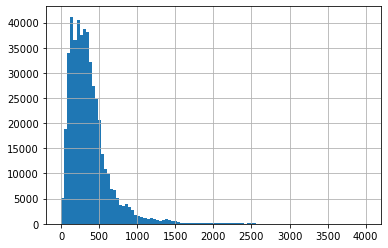

In [4]:
df[df['Length'] < 4000]['Length'].hist(bins=100) # below 4k, i.e. removing outliers

Now we do some data wrangling, in order to obtain a viable multilabel type DataFrame.

We first generate a list of the molecular functions (that are still relative to the full GO database).

We then assign `True` to every label of the generic slim GO subset if one of the labels we obtained above is its descendant.

We then visualize the resulting `DataFrame`.

In [5]:
df['Gene Ontology (molecular function)'] = df['Gene Ontology (molecular function)']\
                                            .apply(lambda x: x.split(";")).apply(lambda x: [el[el.index("[GO")+1:-1] for el in x])

In [6]:
for k in slim_molecular_functions:
    df[ont.node(k)['label']] = df['Gene Ontology (molecular function)']\
                                .apply(lambda x: max([True if el in slim_molecular_functions_descendants[k] else False for el in x]))

In [7]:
ohe_df = df.drop(columns=['Entry', 'Entry Name', 'Protein names', 'Gene Names', 'Organism',
                            'Length', 'Gene Ontology (molecular function)',
                            'Gene Ontology (cellular component)',
                            'Gene Ontology (biological process)', 'Gene Ontology IDs',
                            'Gene Ontology (GO)'])
ohe_df.head()

,Sequence,cargo receptor activity,cell adhesion mediator activity,molecular carrier activity,"catalytic activity, acting on DNA",cyclase activity,molecular transducer activity,lyase activity,transcription regulator activity,ATP-dependent activity,...,general transcription initiation factor activity,hydrolase activity,molecular sequestering activity,oxidoreductase activity,histone binding,catalytic activity,virus receptor activity,virus coreceptor activity,transporter activity,toxin activity
0,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,False,False,False,False,True,False,False,False,False,...,False,True,False,False,False,True,False,False,False,False
1,MRFQVIVAAATITMITSYIPGVASQSTSDGDDLFVPVSNFDPKSIF...,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,True,False,False,False,False
2,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,False,False,False,False,False,False,False,False,True,...,False,True,False,False,False,True,False,False,False,False
3,MRSLAILTTLLAGHAFAYPKPAPQSVNRRDWPSINEFLSELAKVMP...,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,True,False,False,False,False
4,MIVGILTTLATLATLAASVPLEERQACSSVWGQCGGQNWSGPTCCA...,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,True,False,False,False,False


Lastly, we create a `labels` variable that we can use later to get back from the generic vectorial representation of the labels.

We also create said vectorial label representation, which we can then feed to a machine learning model

In [8]:
labels = ohe_df.drop(columns=["Sequence"]).columns
X = df[labels].to_numpy().astype(np.float32)
l = []
for i in range(X.shape[0]):
    l.append(torch.tensor(X[i,:]))

# LLM Fine Tuning (using a Logistic Regression as Classification Head)
This way we take advantage of Logistic Regression multivariate response and perform independent classification of all the various classes while having the gradients all flow through the same model, so as to obtain a better latent space representation of the various sequences.

First we create a `Dataset` object with the vectorial representation of the labels and the relative sequence, then we shuffle (using a seed, 42) and split it in train and test partitions. We use only 1/4 of the reviewed proteins available at UniProt due to runtime issues (training taking too long).

In [9]:
from datasets import Dataset

ds = Dataset.from_dict({"labels": l, "sequence" : df['Sequence']})
ds = ds.shuffle(seed=42).train_test_split(test_size=0.2, seed=42) # both shuffle and split need seed to guarentee determinism, that we need to do training some epochs at a time
ds['train'] = ds['train'].select(range(int(len(ds['train']) / 4))) # otherwise too big 
ds['test'] = ds['test'].select(range(int(len(ds['test']) / 4))) # otherwise too big
ds

DatasetDict({
    train: Dataset({
        features: ['labels', 'sequence'],
        num_rows: 96816
    })
    test: Dataset({
        features: ['labels', 'sequence'],
        num_rows: 24204
    })
})

We instantiate a pre-trained model, ESM, found at https://huggingface.co/docs/transformers/model_doc/esm

It's a transformer based architecture pre-trained on a classical masked language modeling task (predict a given token, in this case an amminoacid in a sequence, given the surrounding context) employing the famous self-attention mechanism.

Given the scarce computational resources at our disposal we use the version of the model with 8 million parameters, although this architecture can go up to 15 billion, which would undoubtedly perform better (having 200x the amount of parameters).

In [10]:
from transformers import AutoTokenizer, EsmModel
import torch
import os

os.environ['TOKENIZERS_PARALLELISM'] = "false"
os.environ["WANDB_DISABLED"] = "true" # disable remote logging

checkpoint = "facebook/esm2_t6_8M_UR50D"

BATCH_SIZE = 3
NUM_EPOCHS = 6

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = EsmModel.from_pretrained(checkpoint)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We tokenize the sequences. As is typical in LLM finetuning we "freeze" the tokenizer, i.e. we do not train the model that produces the embeddings of single tokens but only the language model afterwards which "shifts" the vector representation of the token depending on the surrounding ones.

This model can only handle an input length of 1024 tokens/amminoacids, we therefore truncate everything after this threshold. We have verified before that it will not lose too much information since most proteins are shorter.

In [11]:
def preprocess_tokenize(mapped_ds):
    return tokenizer(mapped_ds['sequence'], truncation=True, max_length=1024)

ds = ds.map(preprocess_tokenize)
ds = ds.remove_columns("sequence")
ds

Map:   0%|          | 0/96816 [00:00<?, ? examples/s]

Map:   0%|          | 0/24204 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 96816
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 24204
    })
})

Now we add to the ESM encoder a custom multilabel classification head: the component we call `self.clf` in the model definition.

We create a subclass of the `torch.nn.Module` class for this purpose.

Moreover we need to define a `MultilabelTrainer` which is a subclass of Huggingface's `transformers.Trainer` base class. Here we need to override the `compute_loss` method to adapt the `BCELoss` to the multilabel use case.

In [12]:
import torch.nn as nn
from transformers import Trainer, TrainingArguments

class ESMwithMultiClass(nn.Module):
    def __init__(self, num_labels=40):
        super().__init__()
        self.llm = model
        self.num_labels = num_labels
        self.clf = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(in_features=model.pooler.dense.in_features, out_features=self.num_labels),
            nn.Sigmoid()
        )

    def forward(self, input_ids, attention_mask, labels=None): # need to return a dict otherwise HF skips first pred when evaluating, god knows why, I had to figure it out from the source code smh 
        return {'logits': self.clf(self.llm(input_ids, attention_mask).pooler_output)} 
    
class MultilabelTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs['logits']
        loss_fct = nn.BCELoss()
        loss = loss_fct(logits.view(-1, self.model.num_labels),
                        labels.float().view(-1, self.model.num_labels))
        loss = loss.mean()
        return (loss, outputs) if return_outputs else loss

Lastly, we define some metrics in the `compute_metrics` function. Since this is a multilabel problem some thought must be put in defining them. Especially considering that we are training what are basically multiple one-vs-all classifiers, therefore most of the predictions will be 0 for everyone of those.

We thus an _F1_ score that is the average of the macro aggregate F1 scores for the various classes (like "DNA binding yes/no") on their own.

We also define a Hamming distance which we then average (implemented with a logical xor since the predictions are taken from a binary alphabet).
It has a nice interpretation: the average number of wrong predictions (be they false negative or false positive) per sample, out of 40 total.

In [13]:
import evaluate
from transformers import DataCollatorWithPadding
from typing import List, Dict, Any

def compute_metrics(eval_pred):
    f1_score = evaluate.load("f1")
    predictions, labels = eval_pred
    predictions = np.where(predictions > 0.5, 1, 0)
    labels = np.where(labels > 0.5, 1, 0)
    f1s = []
    for i in range(40):
        f1s.append(f1_score.compute(predictions=predictions[:, i], references=labels[:, i], average="macro")['f1'])
    average_wrongs = np.logical_xor(predictions, labels).sum(axis=1).mean()
    return {'f1_average' : sum(f1s) / len(f1s), 'hamming_distance' : float(average_wrongs)}

We then set some training arguments such as weight decay and saving and evaluation strategies. We also instatiate our custom `MultilabelTrainer`

In [14]:
training_args = TrainingArguments(
    output_dir="./esm_multilabel",
    learning_rate=3e-4,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    report_to="none",
    logging_steps=1,
)

trainer = MultilabelTrainer( # can you believe that it drops columns that are not explicitly used by the model? damned huggingface 
        model=ESMwithMultiClass(),
        args=training_args,
        train_dataset=ds["train"],
        eval_dataset=ds["test"],
        tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
        compute_metrics=compute_metrics,
    )

We run an evaluation round to ensure everything runs smoothly (i.e. expected Hamming distance is roughly 20 since weights of classification head are randomly initialized). 

We then proceed with the actual training of the model.

In [15]:
trainer.evaluate()

{'eval_loss': 0.689273476600647,
 'eval_f1_average': 0.31015300046110755,
 'eval_hamming_distance': 18.737729300941993,
 'eval_runtime': 329.3768,
 'eval_samples_per_second': 73.484,
 'eval_steps_per_second': 24.495}

In [16]:
import os

trainer.train()
# this takes the last available checkpoint and resumes training from there
#trainer.train(resume_from_checkpoint=f"esm_multilabel/{sorted(os.listdir('esm_multilabel'))[-1]}/")

Epoch,Training Loss,Validation Loss,F1 Average,Hamming Distance
1,0.099800,0.085115,0.683829,1.200669
2,0.072000,0.064689,0.754207,0.885102
3,0.054600,0.049267,0.794177,0.655346
4,0.042000,0.041449,0.811311,0.541894
5,0.031500,0.037880,0.820731,0.488101
6,0.021800,0.037558,0.832346,0.453685


TrainOutput(global_step=193632, training_loss=0.05362507686637055, metrics={'train_runtime': 13739.5577, 'train_samples_per_second': 42.279, 'train_steps_per_second': 14.093, 'total_flos': 0.0, 'train_loss': 0.05362507686637055, 'epoch': 6.0})

As you can see from the columns "F1 Average" and "Hamming Distance", which are calculated on the test set, the models performs well enough. In particular by looking at the Hamming distance we can see that, on the 40 labels we are using, the model gets only 0.45 wrong on average.

Moreover the model has not converged yet; we just stopped the training because it was taking too long (even with only a quarter of the full dataset in use).

Of course with some hyperparameter tuning and more computational resources, so as to be able to use bigger models and more data, the results could be even more impressive.

We finally better quantify the model's performance by employing a multi-label confusion matrix, as described in [Heydarian et al, MLCM: Multi-Label Confusion Matrix](https://www.researchgate.net/publication/358509618_MLCM_Multi-Label_Confusion_Matrix). This is basically the equivalent of a normal confusion matrix but with an additional row and column to signify the absence of all other labels.

On the y-axis we have the ground truth and on the x-axis we have the assigned label.

As we can see from the matrix when the model fails it mostly assigns other (i.e. no label) to any given class. This is not surprising given the nature of the model, which is basically one-vs-all logistic regression (after the encoding stage) with a very high class imbalance.

<AxesSubplot:>

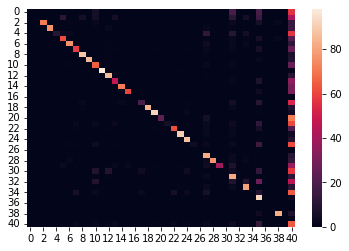

In [17]:
from mlcm import mlcm
import seaborn as sns

predictions, _, _ = trainer.predict(ds["test"])
predictions = np.where(predictions > .5, 1, 0)
references = np.array(ds["test"]['labels'])

conf_mat,normal_conf_mat = mlcm.cm(references, predictions, print_note=False)
sns.heatmap(normal_conf_mat)

#### Future Work

It would be interesting to see how the model performs with the encoder frozen, in particular it could be worthwhile to investigate the latent space representation of the sequences when no further fine-tuning is performed. For example we could cluster the representations in the latent space and then have an expert assess whether the proteins belonging to these clusters share some common traits, either functional or structural or both.